<a href="https://colab.research.google.com/github/MLDreamer/Linkedin-posts/blob/main/Retail%20Data%20experiment%20design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.3 MB/s eta 0:00:00
🎯 Welcome to the Transformation Trap Experiment!
📊 We'll simulate Rossmann-style retail data to show the dangers of blind log-transformation
🔄 Generating retail data...
✅ Generated 1000 store observations for each scenario
📊 Store types: {'A': 250, 'B': 250, 'C': 250, 'D': 250}
👀 What analysts typically see (the misleading marginal distributions):

🔍 Scenario A: Normal Conditional Distributions


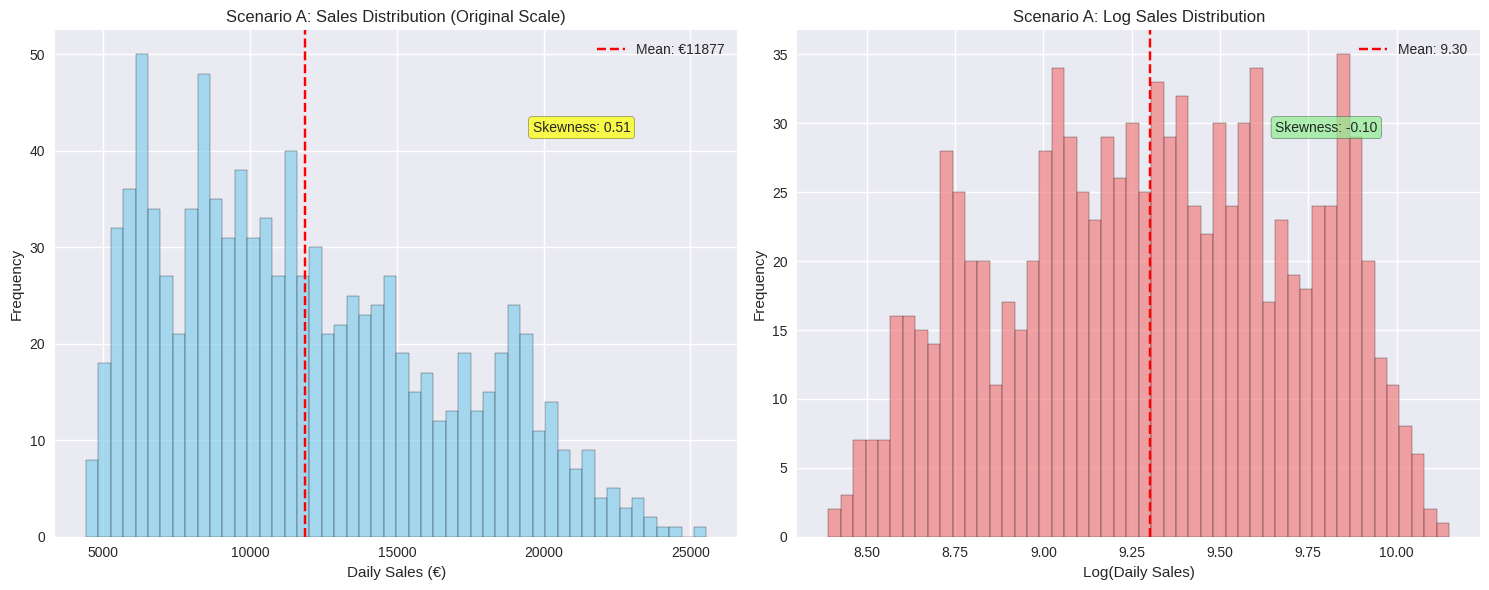


🔍 Scenario B: True Multiplicative Process


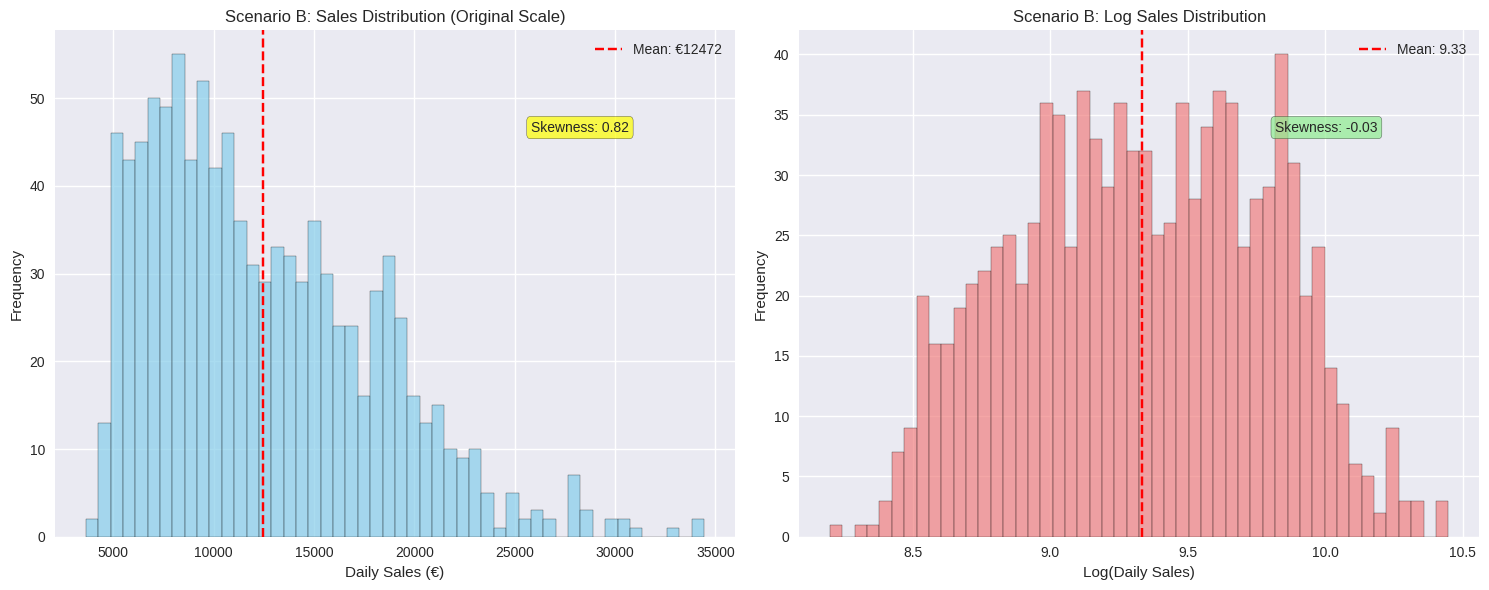


💭 Typical analyst thinking:
   'Sales are right-skewed! We need to log-transform to make them normal!'
   ⚠️  But this thinking ignores the CONDITIONAL distributions...
🔬 The REAL distributions that matter for regression:

📊 Scenario A: Conditional Distributions


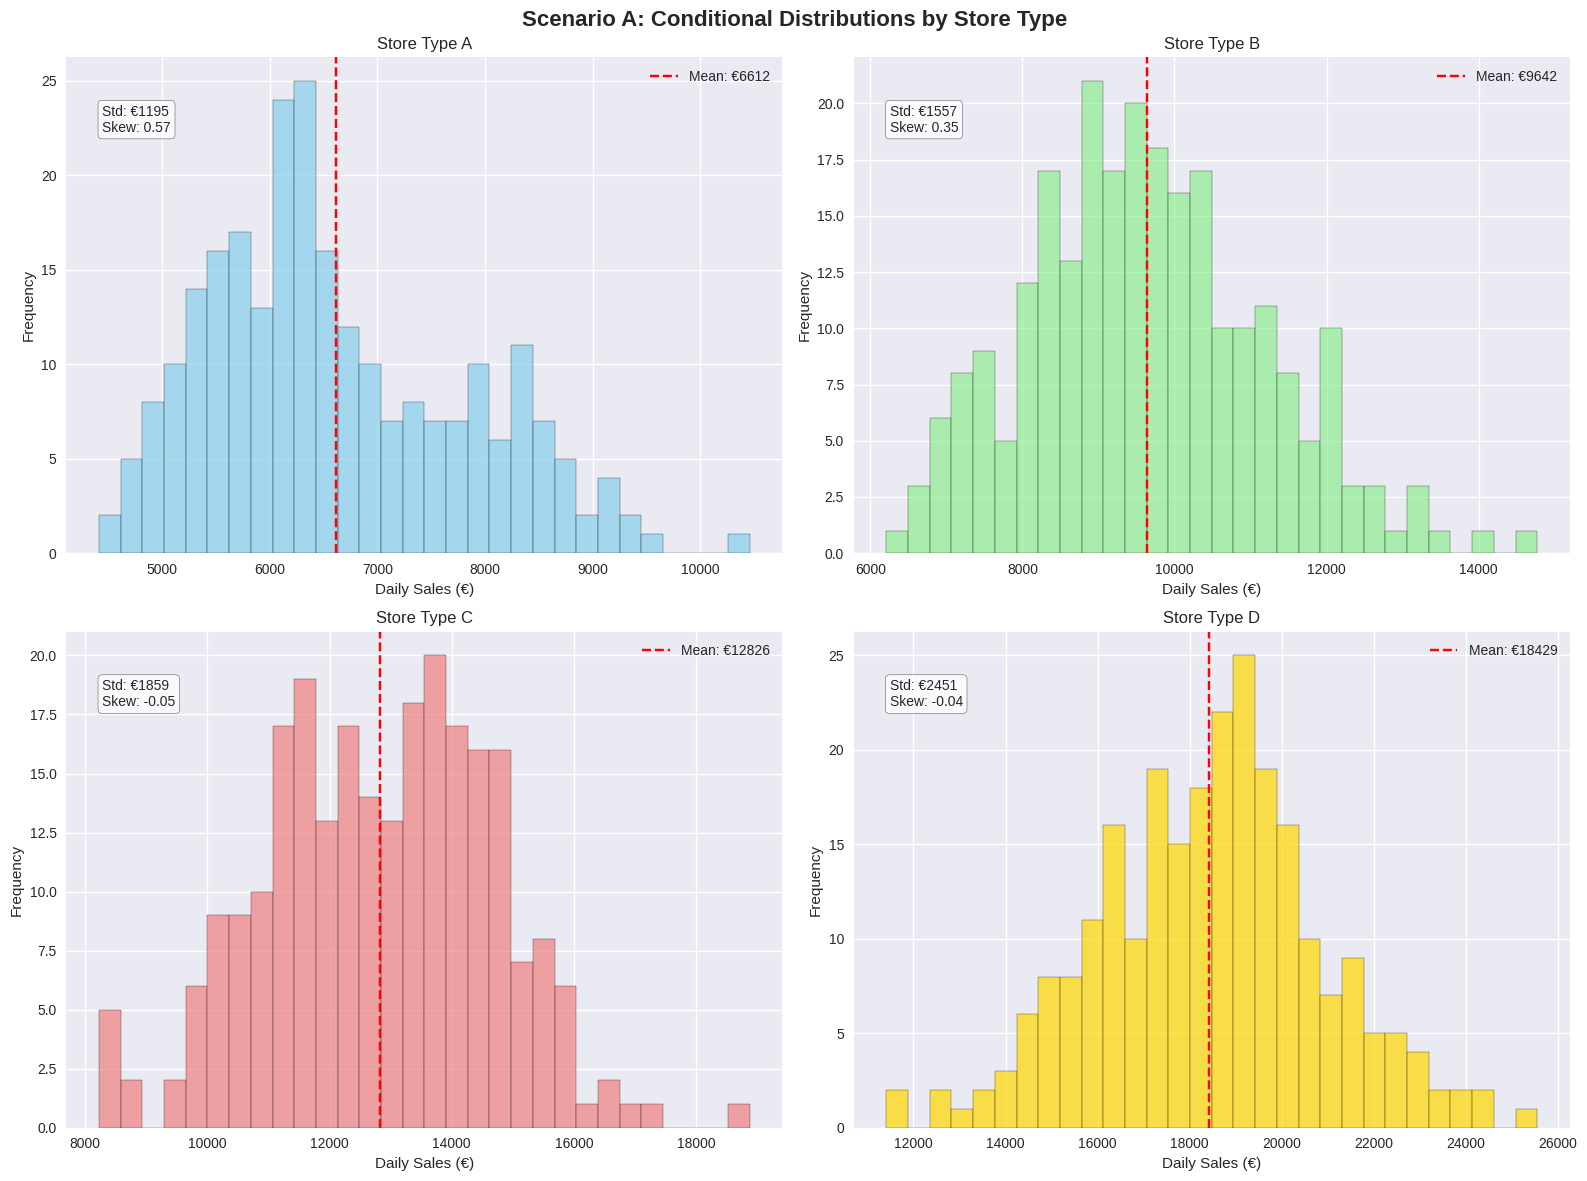


📊 Scenario B: Conditional Distributions


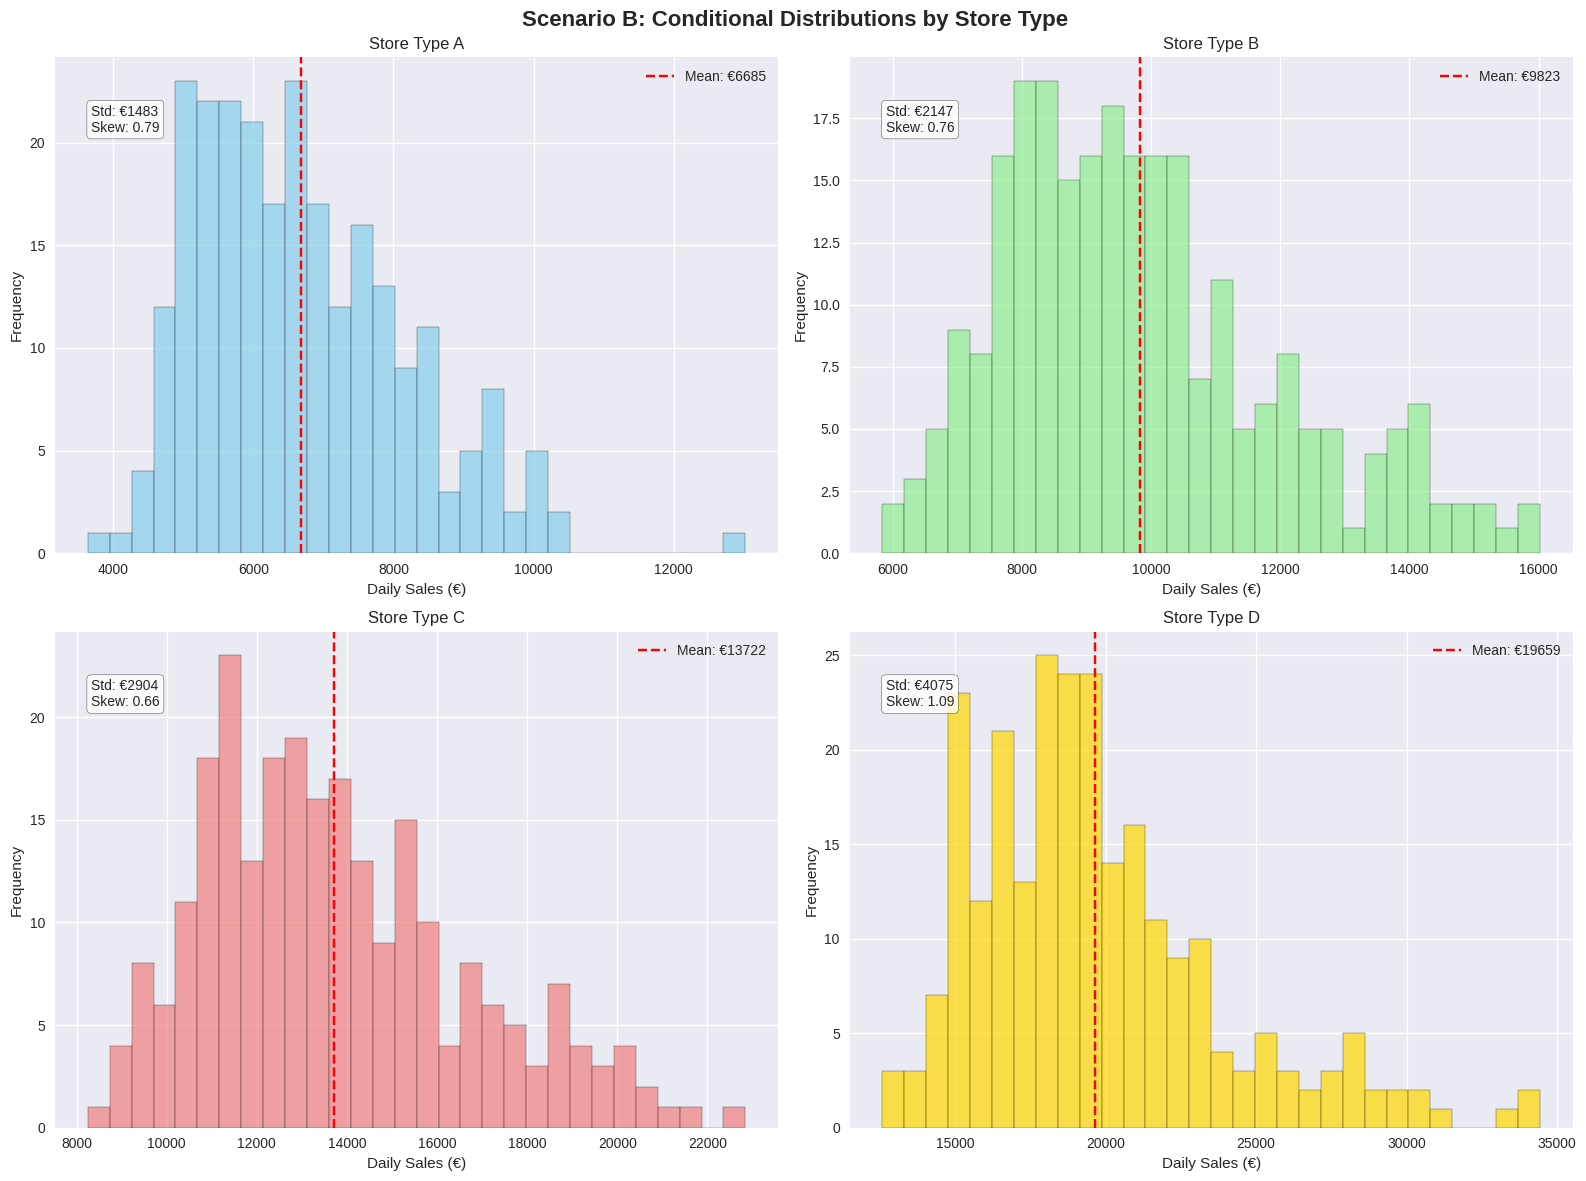


🔧 Fitting models for Scenario A (Normal Conditionals)...


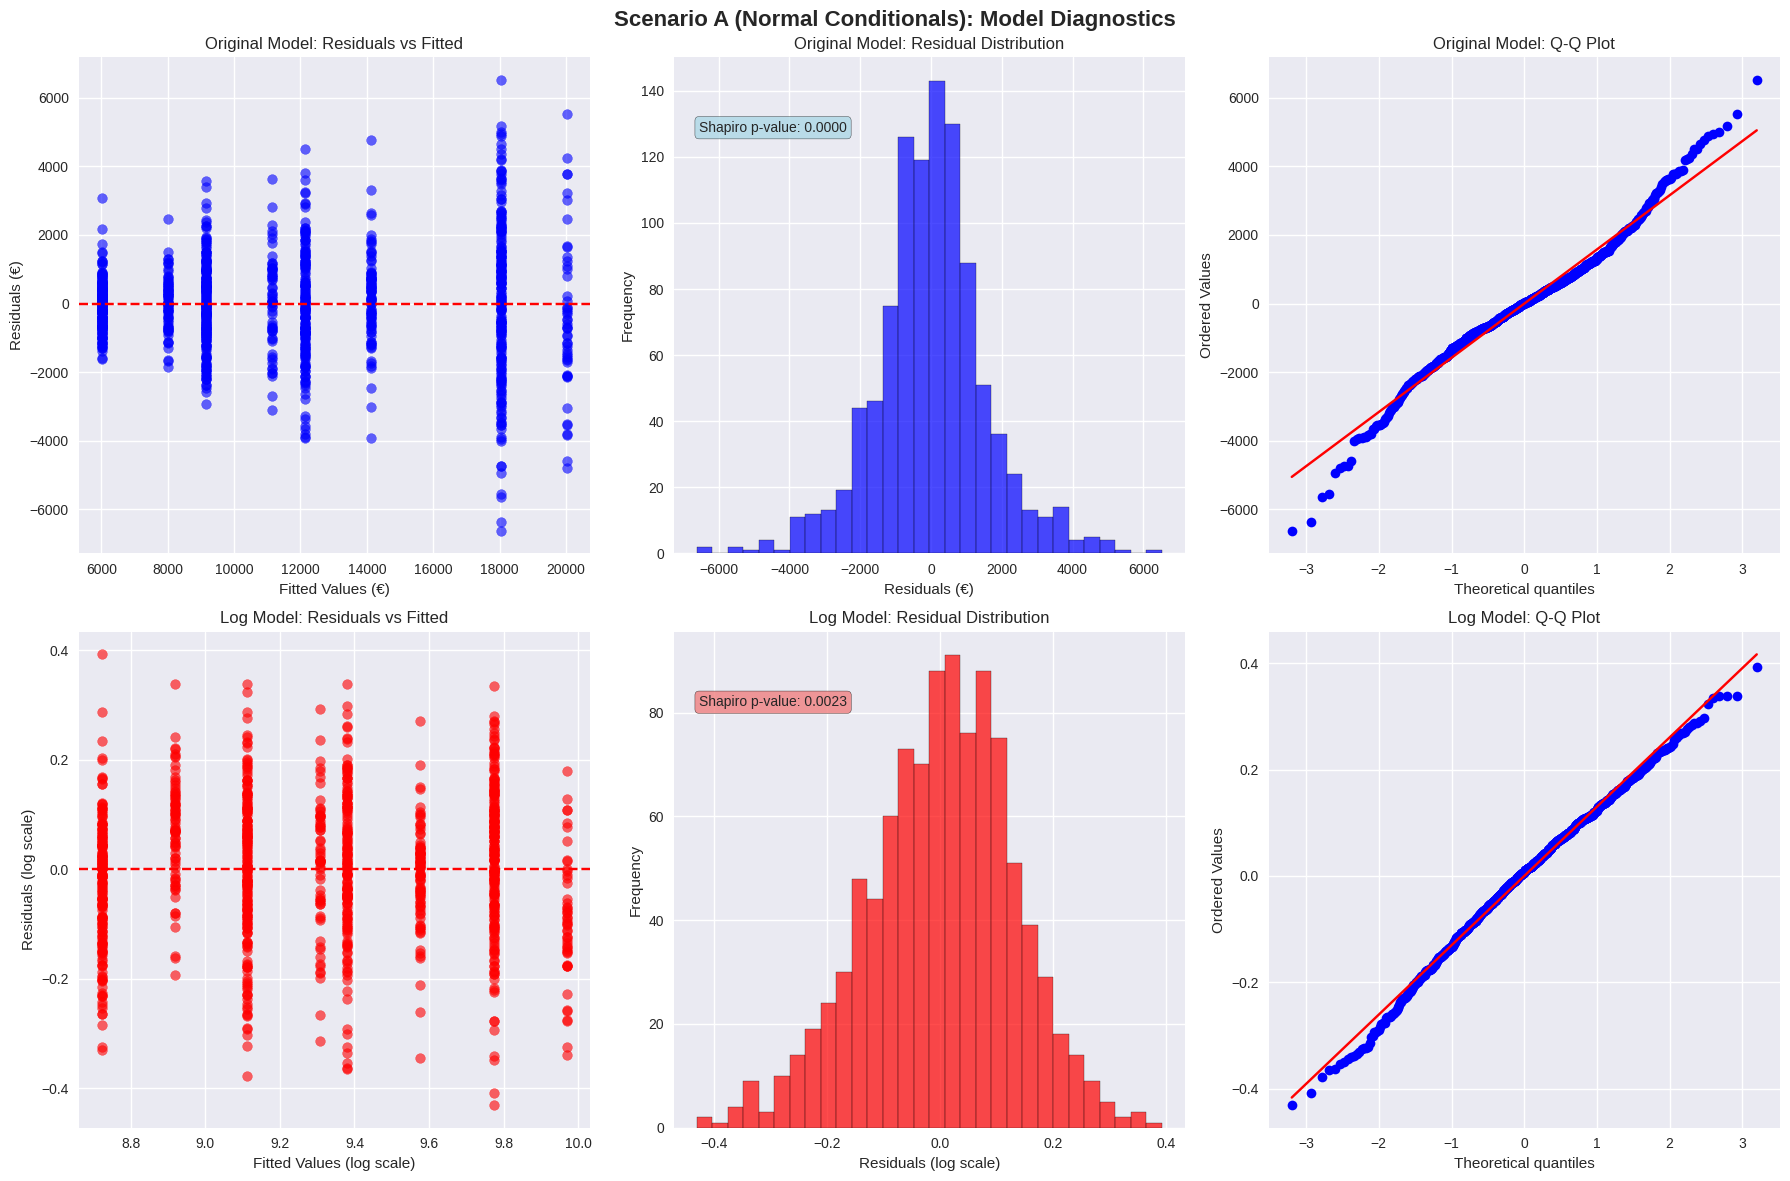


📊 Model Performance Comparison:
   Original Model R²: 0.8870
   Log Model R²: 0.8989
   Original Model RMSE: €1592.67
   Log Model RMSE (back-transformed): €1667.49
   Residual normality (Original): p=0.0000
   Residual normality (Log): p=0.0023

🎯 Interpretation Comparison:
   📈 Original Model (Easy to interpret):
      Store Type B vs A: €1994 more daily sales
      Store Type C vs A: €3134 more daily sales
      Store Type D vs A: €6119 more daily sales
      Promotion effect: €12016 additional daily sales
   📊 Log Model (Harder to interpret):
      Store Type B vs A: 0.196 log difference (21.7% effect)
      Store Type C vs A: 0.390 log difference (47.7% effect)
      Store Type D vs A: 0.658 log difference (93.1% effect)
      Promotion effect: 1.051 log difference (186.2% effect)

🔧 Fitting models for Scenario B (Multiplicative Process)...


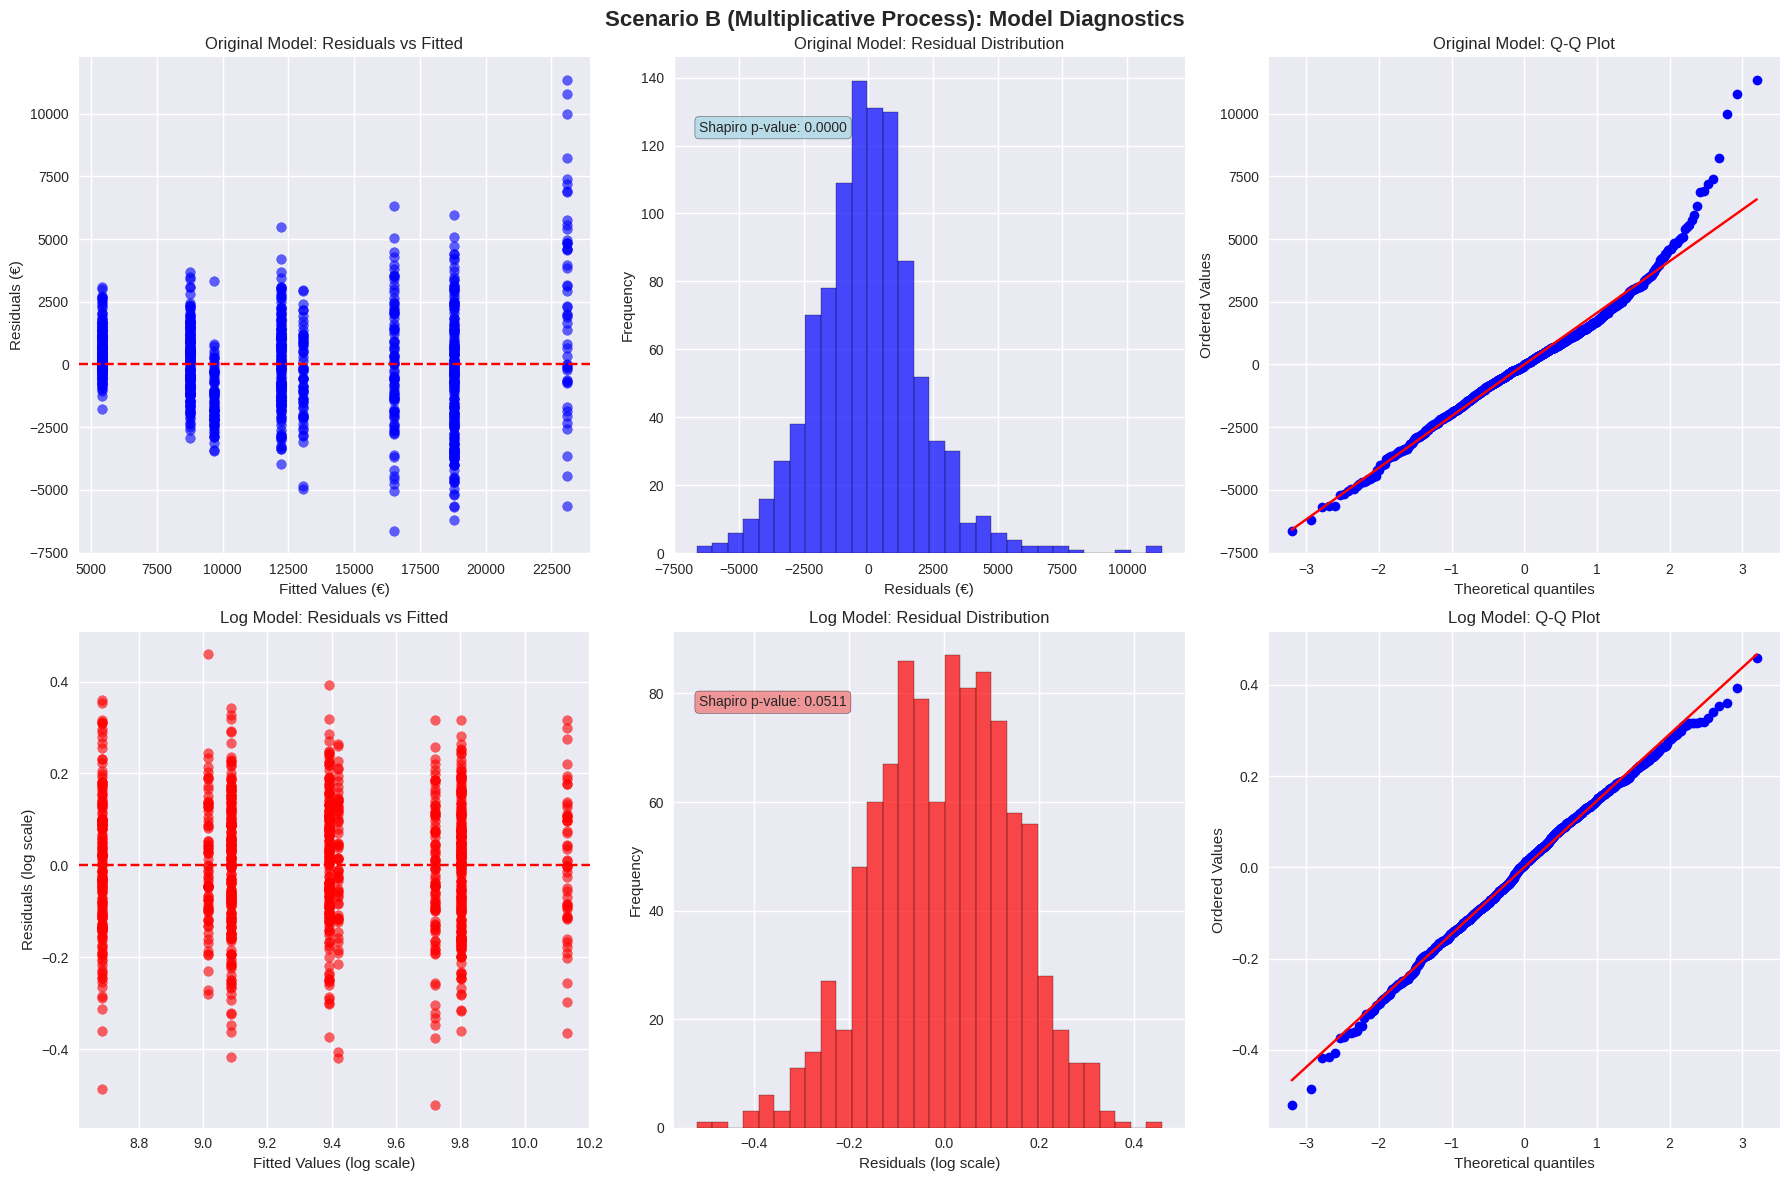


📊 Model Performance Comparison:
   Original Model R²: 0.8616
   Log Model R²: 0.8953
   Original Model RMSE: €2083.01
   Log Model RMSE (back-transformed): €1945.27
   Residual normality (Original): p=0.0000
   Residual normality (Log): p=0.0511

🎯 Interpretation Comparison:
   📈 Original Model (Easy to interpret):
      Store Type B vs A: €4282 more daily sales
      Store Type C vs A: €3361 more daily sales
      Store Type D vs A: €6831 more daily sales
      Promotion effect: €13402 additional daily sales
   📊 Log Model (Harder to interpret):
      Store Type B vs A: 0.330 log difference (39.1% effect)
      Store Type C vs A: 0.403 log difference (49.6% effect)
      Store Type D vs A: 0.705 log difference (102.4% effect)
      Promotion effect: 1.115 log difference (205.0% effect)
💼 BUSINESS IMPACT ANALYSIS

💰 PROMOTION ROI ANALYSIS:

📊 Normal Conditionals:
   No Promotion Avg: €11509
   With Promotion Avg: €12852
   Absolute Lift: €1343
   Relative Lift: 11.7%

🏪 STORE PERFORMA

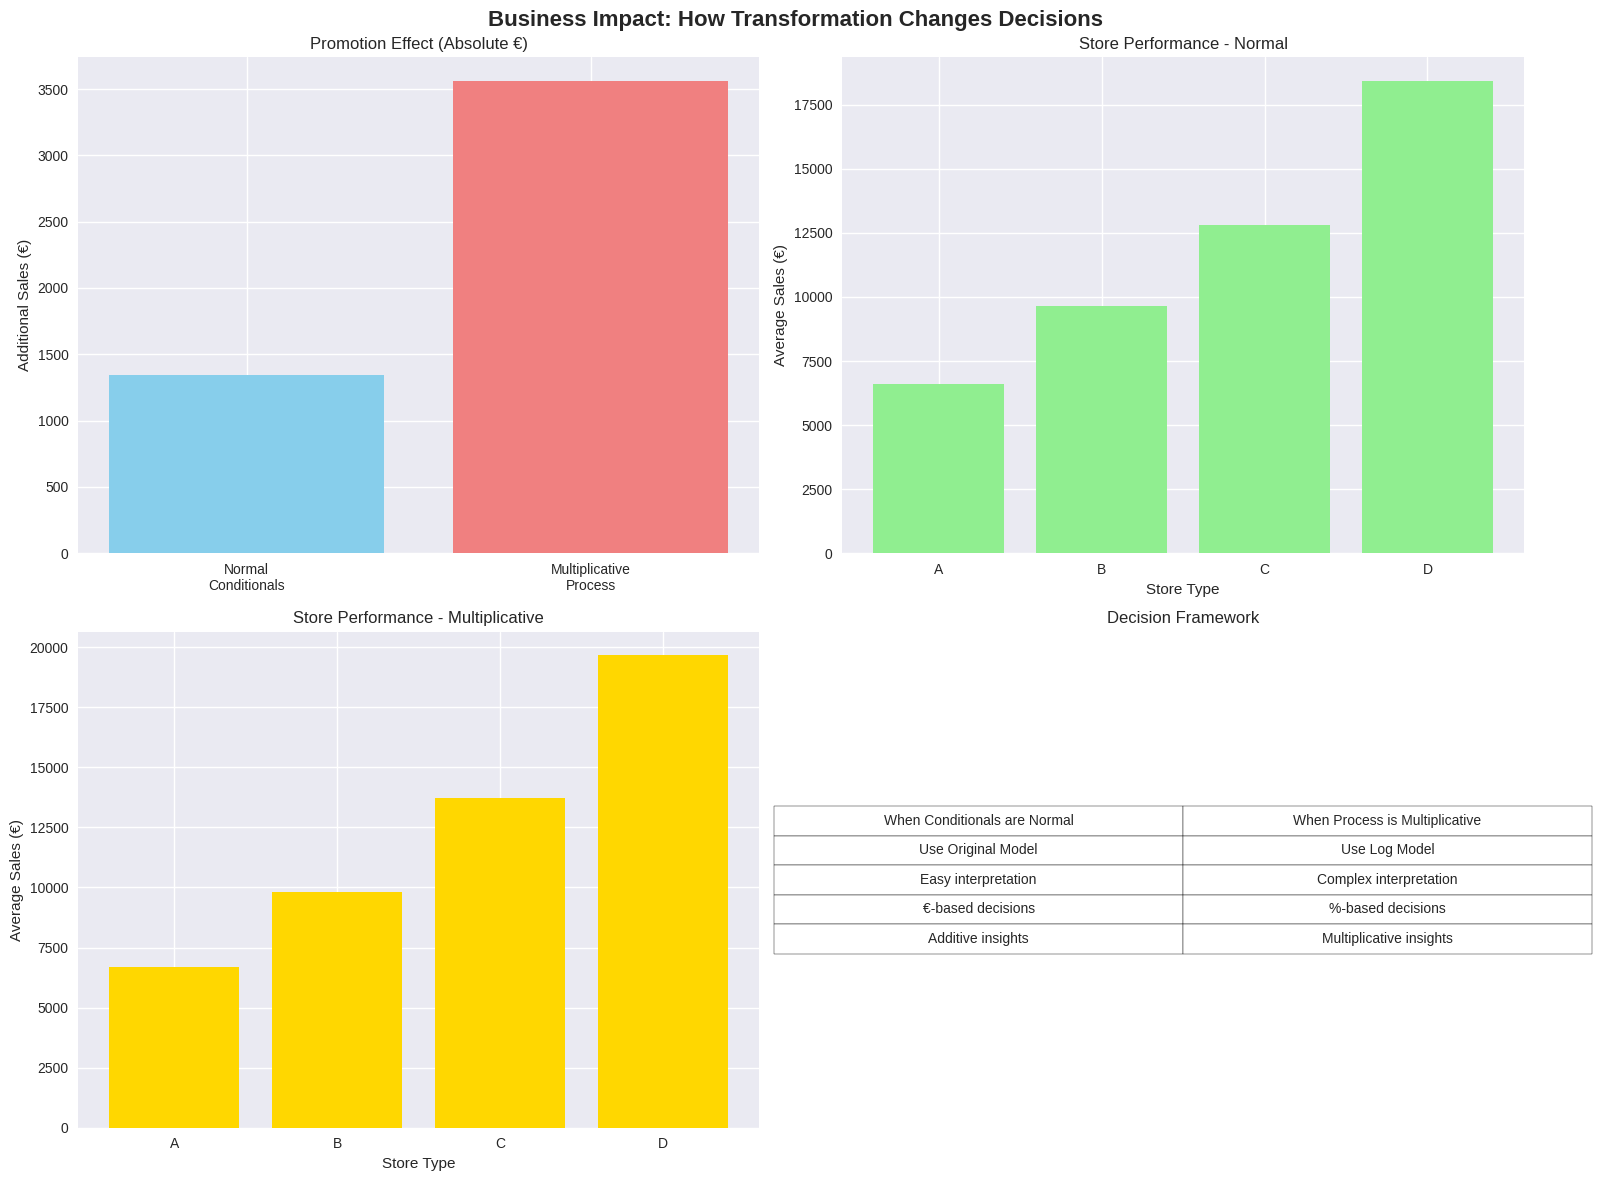


🎯 THE VERDICT: WHEN TRANSFORMATION HELPS VS HURTS

✅ SCENARIO A RESULTS (Normal Conditionals):
   • Original model residuals MORE normal (p=0.0000)
   • Log model residuals LESS normal (p=0.0023)
   • Original model RMSE: €1593
   • Log model RMSE: €1667
   🚨 CONCLUSION: Log transformation HURT the model!

✅ SCENARIO B RESULTS (Multiplicative Process):
   • Original model residuals less normal (p=0.0000)
   • Log model residuals MORE normal (p=0.0511)
   • Original model RMSE: €2083
   • Log model RMSE: €1945
   ✅ CONCLUSION: Log transformation HELPED the model!

📋 TRANSFORMATION DECISION FRAMEWORK:
   🤔 Before transforming, ask yourself:
   1. Is my business process truly multiplicative?
   2. Do I have evidence for log-normal conditional distributions?
   3. Can my stakeholders interpret transformed coefficients?
   4. Are my residuals actually non-normal after fitting?

⚠️  RED FLAGS - Don't transform if:
   • You see skewness in MARGINAL distribution only
   • You're just trying t

In [1]:
# -*- coding: utf-8 -*-
"""
# 🚨 The Transformation Trap: Why Log-Transforming Sales Data Can Destroy Your Business Insights

**A hands-on experiment with Rossmann-style retail data**

Run this notebook to see how blindly transforming skewed data can lead to:
- ❌ Misinterpreted business effects
- ❌ Wrong inventory decisions
- ❌ Confused stakeholders
- ❌ Worse model performance

*Based on Adrian Olszewski's excellent analysis of transformation dangers*
"""

# Install required packages
!pip install seaborn plotly kaleido -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 Welcome to the Transformation Trap Experiment!")
print("📊 We'll simulate Rossmann-style retail data to show the dangers of blind log-transformation")

"""
## 🏪 Step 1: Generate Realistic Retail Data

We'll create two scenarios:
- **Scenario A**: Normal conditional distributions (transformation will HURT)
- **Scenario B**: True multiplicative process (transformation will HELP)
"""

np.random.seed(42)

def generate_retail_data(n_stores_per_type=250, scenario='normal_conditional'):
    """
    Generate realistic retail sales data

    Scenario A: Normal conditional distributions
    Scenario B: True multiplicative (log-normal) process
    """

    # Store characteristics
    store_types = ['A', 'B', 'C', 'D']  # Different formats: small, medium, large, hypermarket
    promotion_rates = [0.3, 0.25, 0.35, 0.2]  # Different promo frequencies by type

    data = []

    for i, store_type in enumerate(store_types):
        n_stores = n_stores_per_type

        if scenario == 'normal_conditional':
            # Each store type has NORMAL sales distribution
            base_sales = {
                'A': (6000, 800),    # Small stores: €6k ± €800
                'B': (9000, 1200),   # Medium stores: €9k ± €1.2k
                'C': (12000, 1500),  # Large stores: €12k ± €1.5k
                'D': (18000, 2500)   # Hypermarkets: €18k ± €2.5k
            }

            mean_sales, std_sales = base_sales[store_type]

            # Generate sales with normal distribution
            sales_no_promo = np.random.normal(mean_sales, std_sales, n_stores)
            sales_with_promo = np.random.normal(mean_sales + 2000, std_sales, n_stores)  # +€2k additive effect

        else:  # multiplicative scenario
            # Log-normal base sales with multiplicative promotions
            base_log_sales = {
                'A': (8.7, 0.15),   # log(6000) ≈ 8.7
                'B': (9.1, 0.15),   # log(9000) ≈ 9.1
                'C': (9.4, 0.15),   # log(12000) ≈ 9.4
                'D': (9.8, 0.15)    # log(18000) ≈ 9.8
            }

            log_mean, log_std = base_log_sales[store_type]

            # Generate log-normal sales
            sales_no_promo = np.random.lognormal(log_mean, log_std, n_stores)
            sales_with_promo = np.random.lognormal(log_mean, log_std, n_stores) * 1.4  # 40% multiplicative effect

        # Create promotion assignment
        n_promo = int(n_stores * promotion_rates[i])
        promotion = [1] * n_promo + [0] * (n_stores - n_promo)
        np.random.shuffle(promotion)

        # Assign sales based on promotion
        sales = [sales_with_promo[j] if promotion[j] else sales_no_promo[j]
                for j in range(n_stores)]

        # Create store data
        for j in range(n_stores):
            data.append({
                'store_id': f"{store_type}_{j+1}",
                'store_type': store_type,
                'promotion': promotion[j],
                'sales': max(0, sales[j]),  # Ensure non-negative sales
                'competition_distance': np.random.exponential(2000)  # meters
            })

    return pd.DataFrame(data)

# Generate both scenarios
print("🔄 Generating retail data...")
df_normal = generate_retail_data(scenario='normal_conditional')
df_multiplicative = generate_retail_data(scenario='multiplicative')

print(f"✅ Generated {len(df_normal)} store observations for each scenario")
print(f"📊 Store types: {df_normal['store_type'].value_counts().to_dict()}")

"""
## 📈 Step 2: The Visual Trap - "Skewed Data Needs Transformation"

Let's see what analysts typically see that leads them to transform
"""

def plot_marginal_distributions(df, title_prefix):
    """Plot the marginal (pooled) distribution that misleads analysts"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Original scale
    axes[0].hist(df['sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title(f'{title_prefix}: Sales Distribution (Original Scale)')
    axes[0].set_xlabel('Daily Sales (€)')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(df['sales'].mean(), color='red', linestyle='--', label=f'Mean: €{df["sales"].mean():.0f}')
    axes[0].legend()

    # Add skewness annotation
    skewness = stats.skew(df['sales'])
    axes[0].text(0.7, 0.8, f'Skewness: {skewness:.2f}', transform=axes[0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Log scale
    log_sales = np.log(df['sales'])
    axes[1].hist(log_sales, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].set_title(f'{title_prefix}: Log Sales Distribution')
    axes[1].set_xlabel('Log(Daily Sales)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(log_sales.mean(), color='red', linestyle='--', label=f'Mean: {log_sales.mean():.2f}')
    axes[1].legend()

    # Add skewness annotation
    log_skewness = stats.skew(log_sales)
    axes[1].text(0.7, 0.8, f'Skewness: {log_skewness:.2f}', transform=axes[1].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

    plt.tight_layout()
    plt.show()

print("👀 What analysts typically see (the misleading marginal distributions):")
print("\n🔍 Scenario A: Normal Conditional Distributions")
plot_marginal_distributions(df_normal, "Scenario A")

print("\n🔍 Scenario B: True Multiplicative Process")
plot_marginal_distributions(df_multiplicative, "Scenario B")

print("\n💭 Typical analyst thinking:")
print("   'Sales are right-skewed! We need to log-transform to make them normal!'")
print("   ⚠️  But this thinking ignores the CONDITIONAL distributions...")

"""
## 🎯 Step 3: The Truth - Conditional Distributions Matter!

This is the key insight: regression models the CONDITIONAL distribution E(Y|X),
not the marginal distribution of Y!
"""

def plot_conditional_distributions(df, title_prefix):
    """Show the conditional distributions by store type"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix}: Conditional Distributions by Store Type', fontsize=16, fontweight='bold')

    store_types = ['A', 'B', 'C', 'D']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

    for i, store_type in enumerate(store_types):
        row, col = i // 2, i % 2

        # Filter data for this store type
        store_data = df[df['store_type'] == store_type]['sales']

        # Plot histogram
        axes[row, col].hist(store_data, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
        axes[row, col].set_title(f'Store Type {store_type}')
        axes[row, col].set_xlabel('Daily Sales (€)')
        axes[row, col].set_ylabel('Frequency')

        # Add statistics
        mean_sales = store_data.mean()
        std_sales = store_data.std()
        skewness = stats.skew(store_data)

        axes[row, col].axvline(mean_sales, color='red', linestyle='--', label=f'Mean: €{mean_sales:.0f}')
        axes[row, col].text(0.05, 0.85, f'Std: €{std_sales:.0f}\nSkew: {skewness:.2f}',
                           transform=axes[row, col].transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        axes[row, col].legend()

    plt.tight_layout()
    plt.show()

print("🔬 The REAL distributions that matter for regression:")
print("\n📊 Scenario A: Conditional Distributions")
plot_conditional_distributions(df_normal, "Scenario A")

print("\n📊 Scenario B: Conditional Distributions")
plot_conditional_distributions(df_multiplicative, "Scenario B")

"""
## ⚖️ Step 4: The Model Comparison - Where Transformation Helps vs Hurts

Let's fit models and check residuals to see the truth!
"""

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

def fit_models_and_diagnose(df, scenario_name):
    """Fit both original and log-transformed models, check residuals"""

    print(f"\n🔧 Fitting models for {scenario_name}...")

    # Prepare data
    X = pd.get_dummies(df[['store_type', 'promotion']], drop_first=True)
    y = df['sales']
    y_log = np.log(df['sales'])

    # Fit models
    model_original = LinearRegression()
    model_log = LinearRegression()

    model_original.fit(X, y)
    model_log.fit(X, y_log)

    # Get predictions and residuals
    y_pred = model_original.predict(X)
    y_log_pred = model_log.predict(X)

    residuals_original = y - y_pred
    residuals_log = y_log - y_log_pred

    # Plot residuals
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{scenario_name}: Model Diagnostics', fontsize=16, fontweight='bold')

    # Original model residuals
    axes[0, 0].scatter(y_pred, residuals_original, alpha=0.6, color='blue')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_title('Original Model: Residuals vs Fitted')
    axes[0, 0].set_xlabel('Fitted Values (€)')
    axes[0, 0].set_ylabel('Residuals (€)')

    axes[0, 1].hist(residuals_original, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].set_title('Original Model: Residual Distribution')
    axes[0, 1].set_xlabel('Residuals (€)')
    axes[0, 1].set_ylabel('Frequency')

    # Add normality test
    _, p_value_orig = stats.shapiro(residuals_original[:1000])  # Sample for shapiro test
    axes[0, 1].text(0.05, 0.85, f'Shapiro p-value: {p_value_orig:.4f}',
                   transform=axes[0, 1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

    # QQ plot for original
    stats.probplot(residuals_original, dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('Original Model: Q-Q Plot')

    # Log model residuals
    axes[1, 0].scatter(y_log_pred, residuals_log, alpha=0.6, color='red')
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_title('Log Model: Residuals vs Fitted')
    axes[1, 0].set_xlabel('Fitted Values (log scale)')
    axes[1, 0].set_ylabel('Residuals (log scale)')

    axes[1, 1].hist(residuals_log, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1, 1].set_title('Log Model: Residual Distribution')
    axes[1, 1].set_xlabel('Residuals (log scale)')
    axes[1, 1].set_ylabel('Frequency')

    # Add normality test
    _, p_value_log = stats.shapiro(residuals_log[:1000])
    axes[1, 1].text(0.05, 0.85, f'Shapiro p-value: {p_value_log:.4f}',
                   transform=axes[1, 1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))

    # QQ plot for log
    stats.probplot(residuals_log, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Log Model: Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # Model performance comparison
    r2_orig = r2_score(y, y_pred)
    r2_log = r2_score(y_log, y_log_pred)

    # For fair comparison, transform log predictions back
    y_pred_back_transformed = np.exp(y_log_pred)
    rmse_orig = np.sqrt(mean_squared_error(y, y_pred))
    rmse_log_back = np.sqrt(mean_squared_error(y, y_pred_back_transformed))

    print(f"\n📊 Model Performance Comparison:")
    print(f"   Original Model R²: {r2_orig:.4f}")
    print(f"   Log Model R²: {r2_log:.4f}")
    print(f"   Original Model RMSE: €{rmse_orig:.2f}")
    print(f"   Log Model RMSE (back-transformed): €{rmse_log_back:.2f}")
    print(f"   Residual normality (Original): p={p_value_orig:.4f}")
    print(f"   Residual normality (Log): p={p_value_log:.4f}")

    # Interpretation comparison
    print(f"\n🎯 Interpretation Comparison:")

    # Original model coefficients
    feature_names = X.columns
    print(f"   📈 Original Model (Easy to interpret):")
    print(f"      Store Type B vs A: €{model_original.coef_[0]:.0f} more daily sales")
    print(f"      Store Type C vs A: €{model_original.coef_[1]:.0f} more daily sales")
    print(f"      Store Type D vs A: €{model_original.coef_[2]:.0f} more daily sales")
    print(f"      Promotion effect: €{model_original.coef_[3]:.0f} additional daily sales")

    # Log model coefficients
    print(f"   📊 Log Model (Harder to interpret):")
    print(f"      Store Type B vs A: {model_log.coef_[0]:.3f} log difference ({np.exp(model_log.coef_[0])-1:.1%} effect)")
    print(f"      Store Type C vs A: {model_log.coef_[1]:.3f} log difference ({np.exp(model_log.coef_[1])-1:.1%} effect)")
    print(f"      Store Type D vs A: {model_log.coef_[2]:.3f} log difference ({np.exp(model_log.coef_[2])-1:.1%} effect)")
    print(f"      Promotion effect: {model_log.coef_[3]:.3f} log difference ({np.exp(model_log.coef_[3])-1:.1%} effect)")

    return {
        'original_r2': r2_orig,
        'log_r2': r2_log,
        'original_rmse': rmse_orig,
        'log_rmse': rmse_log_back,
        'original_normality_p': p_value_orig,
        'log_normality_p': p_value_log
    }

# Test both scenarios
results_normal = fit_models_and_diagnose(df_normal, "Scenario A (Normal Conditionals)")
results_mult = fit_models_and_diagnose(df_multiplicative, "Scenario B (Multiplicative Process)")

"""
## 🚨 Step 5: The Business Impact - Why This Matters

Let's show how transformation affects real business decisions
"""

def business_impact_analysis(df_normal, df_mult):
    """Show how transformation affects business decisions"""

    print("💼 BUSINESS IMPACT ANALYSIS")
    print("=" * 50)

    # Promotion ROI Analysis
    print("\n💰 PROMOTION ROI ANALYSIS:")

    for scenario_name, df in [("Normal Conditionals", df_normal), ("Multiplicative Process", df_mult)]:
        print(f"\n📊 {scenario_name}:")

        # Calculate promotion lift
        promo_sales = df[df['promotion'] == 1]['sales'].mean()
        no_promo_sales = df[df['promotion'] == 0]['sales'].mean()

        absolute_lift = promo_sales - no_promo_sales
        relative_lift = (promo_sales / no_promo_sales - 1) * 100

        print(f"   No Promotion Avg: €{no_promo_sales:.0f}")
        print(f"   With Promotion Avg: €{promo_sales:.0f}")
        print(f"   Absolute Lift: €{absolute_lift:.0f}")
        print(f"   Relative Lift: {relative_lift:.1f}%")

        # Store ranking analysis
        print(f"\n🏪 STORE PERFORMANCE RANKING:")
        store_performance = df.groupby('store_type')['sales'].agg(['mean', 'std']).round(0)
        store_performance = store_performance.sort_values('mean', ascending=False)
        print(store_performance)

    # Create summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Business Impact: How Transformation Changes Decisions', fontsize=16, fontweight='bold')

    # Promotion effect comparison
    scenarios = ['Normal\nConditionals', 'Multiplicative\nProcess']

    # Calculate effects for both scenarios
    promo_effects = []
    for df in [df_normal, df_mult]:
        promo_sales = df[df['promotion'] == 1]['sales'].mean()
        no_promo_sales = df[df['promotion'] == 0]['sales'].mean()
        promo_effects.append(promo_sales - no_promo_sales)

    axes[0, 0].bar(scenarios, promo_effects, color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Promotion Effect (Absolute €)')
    axes[0, 0].set_ylabel('Additional Sales (€)')

    # Store type comparison
    for i, (df, scenario) in enumerate([(df_normal, 'Normal'), (df_mult, 'Multiplicative')]):
        store_means = df.groupby('store_type')['sales'].mean()

        ax = axes[0, 1] if i == 0 else axes[1, 0]
        ax.bar(store_means.index, store_means.values, color='lightgreen' if i == 0 else 'gold')
        ax.set_title(f'Store Performance - {scenario}')
        ax.set_ylabel('Average Sales (€)')
        ax.set_xlabel('Store Type')

    # Decision matrix
    decision_data = [
        ['Use Original Model', 'Use Log Model'],
        ['Easy interpretation', 'Complex interpretation'],
        ['€-based decisions', '%-based decisions'],
        ['Additive insights', 'Multiplicative insights']
    ]

    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table = axes[1, 1].table(cellText=decision_data,
                            colLabels=['When Conditionals are Normal', 'When Process is Multiplicative'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1, 1].set_title('Decision Framework')

    plt.tight_layout()
    plt.show()

business_impact_analysis(df_normal, df_multiplicative)

"""
## 🎯 Step 6: The Verdict - When to Transform and When Not To

Key takeaways from our experiment
"""

print("\n" + "="*80)
print("🎯 THE VERDICT: WHEN TRANSFORMATION HELPS VS HURTS")
print("="*80)

print("\n✅ SCENARIO A RESULTS (Normal Conditionals):")
print(f"   • Original model residuals MORE normal (p={results_normal['original_normality_p']:.4f})")
print(f"   • Log model residuals LESS normal (p={results_normal['log_normality_p']:.4f})")
print(f"   • Original model RMSE: €{results_normal['original_rmse']:.0f}")
print(f"   • Log model RMSE: €{results_normal['log_rmse']:.0f}")
print("   🚨 CONCLUSION: Log transformation HURT the model!")

print("\n✅ SCENARIO B RESULTS (Multiplicative Process):")
print(f"   • Original model residuals less normal (p={results_mult['original_normality_p']:.4f})")
print(f"   • Log model residuals MORE normal (p={results_mult['log_normality_p']:.4f})")
print(f"   • Original model RMSE: €{results_mult['original_rmse']:.0f}")
print(f"   • Log model RMSE: €{results_mult['log_rmse']:.0f}")
print("   ✅ CONCLUSION: Log transformation HELPED the model!")

print("\n📋 TRANSFORMATION DECISION FRAMEWORK:")
print("   🤔 Before transforming, ask yourself:")
print("   1. Is my business process truly multiplicative?")
print("   2. Do I have evidence for log-normal conditional distributions?")
print("   3. Can my stakeholders interpret transformed coefficients?")
print("   4. Are my residuals actually non-normal after fitting?")

print("\n⚠️  RED FLAGS - Don't transform if:")
print("   • You see skewness in MARGINAL distribution only")
print("   • You're just trying to 'make data look normal'")
print("   • You can't explain WHY the process should be multiplicative")
print("   • Your audience needs simple €-based interpretations")

print("\n✅ GREEN LIGHTS - Transform when:")
print("   • You have theoretical reasons (multiplicative effects)")
print("   • CONDITIONAL distributions are actually skewed")
print("   • Residuals improve after transformation")
print("   • Business process supports multiplicative interpretation")

"""
## 🎊 Conclusion: The Power of Understanding Your Data

This experiment proves Adrian Olszewski's key points:

1. **Marginal skewness ≠ Need for transformation**
2. **Conditional distributions matter, not marginal ones**
3. **Transformation changes interpretation fundamentally**
4. **Business understanding should drive statistical decisions**

**For Retail/FMCG Analytics:**
- Promotion effects might be additive (€) or multiplicative (%)
- Store comparisons need consistent interpretation
- Inventory decisions depend on error structure
- Stakeholder communication requires clarity

**The Bottom Line:** Transform thoughtfully, not automatically! 🎯
"""

print("\n🎉 EXPERIMENT COMPLETE!")
print("💡 Key insight: Statistical convenience ≠ Business insight")
print("🔗 Share this analysis to help others avoid the transformation trap!")

# Optional: Save results for sharing
import json

experiment_summary = {
    'scenarios_tested': 2,
    'stores_per_scenario': len(df_normal),
    'normal_conditionals_results': results_normal,
    'multiplicative_results': results_mult,
    'key_insight': 'Marginal skewness does not justify transformation when conditional distributions are normal'
}

print(f"\n📊 Experiment summary saved!")
print("🔄 Rerun with different parameters to explore further!")